Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/7998b8a481fccd467463deb1fc46d19622079b0e/LICENSE.md)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.common.utils.encoding import CatEncoder

In [2]:
# Example will use a simple logistic classifier on the German Credit dataset
base_path = '..'
all_data_file = f"{base_path}/datasets/german_credit_eval.csv"

df = pd.read_csv(all_data_file)

# Since we're exploring fairness by unawareness we'll do several analyses.  In the original
# dataset the model has access to the protected grouping features of 'age' and 'status'.  We will explore
# two variations:
# 
# Firstly we'll build a model that does not have access to the protected features and see to waht degree
# that imporves fairness (this is fairness by unawareness)
# Secondly we'll add an extra protected feature ('pseudo') which is randomly assigned and thus has no correlation
# to anything else - this will act as a baseline for how fair we could expect a model to be that truly has no
# information about a protected feature even through correlated features
omitted_features = ['status', 'age', 'pseudo']

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'others',
    'status',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign',
    'pseudo'
    ]

#deterministic results
np.random.seed(42)

# Add pseudo-feature randomly
perm = np.random.permutation(len(df))
A_idx = perm[:int(len(df)/2)]
B_idx = perm[int(len(df)/2):]
pseudo_feature = np.empty(len(df), dtype=object)
pseudo_feature[A_idx] = 'A'
pseudo_feature[B_idx] = 'B'
df['pseudo'] = pseudo_feature

label_column = 'outcome'

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

# Build models on both the reduced dataset and the full one

# Drop the omitted column(s) and train a model without them
X_reduced = X.drop(omitted_features, axis=1)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)
encoder_reduced = CatEncoder([f for f in cat_columns if f not in omitted_features], X_reduced)

# Measure accuracy for a constant predict-mode classifier
print(f"Accuracy of modal predictor: {sum(y == 1)/len(y)}")

def build_model(data, name):
    parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
    svc = svm.SVC()
    model = GridSearchCV(svc, parameters, cv=3)
    model.fit(data, y)

    # Assess on the full data
    accuracy = model.score(data, y.values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

model = build_model(encoder(X.values), 'aware')
model_unaware = build_model(encoder_reduced(X_reduced.values), 'unaware')


Accuracy of modal predictor: 0.7
Model 'aware' accuracy is 0.781
Model 'unaware' accuracy is 0.867


In [3]:
# Wrap the model up for use by Certifai as a local model
model_proxy = CertifaiPredictorWrapper(model, encoder=encoder)
model_proxy_unaware = CertifaiPredictorWrapper(model_unaware, encoder=encoder_reduced)


In [4]:
df.groupby(['outcome']).size()

outcome
1    700
2    300
dtype: int64

In [5]:
# Create the scan object from scratch using the ScanBuilder class

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)

# Add our local model
first_model = CertifaiModel('aware',
                            local_predictor=model_proxy)
scan.add_model(first_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.dataframe(df))
scan.add_dataset(eval_dataset)

# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity in the features we hid from the model
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('pseudo'))
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)


2020-10-14 14:29:03,664 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)


Starting scan with model_use_case_id: 'test_user_case' and scan_id: '4bc05a9739d5'
[--------------------] 2020-10-14 14:29:03.649962 - 0 of 1 reports (0.0% complete) - Running fairness evaluation for model: aware


2020-10-14 14:29:41,882 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2020-10-14 14:29:57,767 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2020-10-14 14:30:29,105 root   WARNING  Examples of protected class ('age', '<= 25 years') exhausted before convergence after 190 samples
2020-10-14 14:30:45,736 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-10-14 14:30:47,650 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples
2020-10-14 14:30:47,651 root   WARNING  Examples of protected class ('pseudo', 'B') exhausted before convergence after 500 samples
2020-10-14 14:30:47,652 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence

[####################] 2020-10-14 14:31:03.338390 - 1 of 1 reports (100.0% complete) - Completed all evaluations


In [6]:
# Repeat for the reduced model
# Note - we have to do this as a separate analysis because we're using models with a different
# signature (so a different schema) which cannot be encompassed in a single scan
scan.remove_model('aware')
reduced_model = CertifaiModel('unaware',
                            local_predictor=model_proxy_unaware)
scan.add_model(reduced_model)

# Tell Certifai the fields which we omitted from the model
scan.dataset_schema.hidden_feature_names = omitted_features

result2 = scan.run(write_reports=False)

2020-10-14 14:31:03,394 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)


[--------------------] 2020-10-14 14:31:03.380561 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'test_user_case' and scan_id: 'acd890fd608a'
[--------------------] 2020-10-14 14:31:03.380736 - 0 of 1 reports (0.0% complete) - Running fairness evaluation for model: unaware


2020-10-14 14:31:45,442 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2020-10-14 14:32:03,648 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2020-10-14 14:32:39,373 root   WARNING  Examples of protected class ('age', '<= 25 years') exhausted before convergence after 190 samples
2020-10-14 14:33:15,667 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-10-14 14:33:19,516 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples
2020-10-14 14:33:19,517 root   WARNING  Examples of protected class ('pseudo', 'B') exhausted before convergence after 500 samples
2020-10-14 14:33:19,518 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence

[####################] 2020-10-14 14:33:35.150985 - 1 of 1 reports (100.0% complete) - Completed all evaluations


,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (<= 25 years),Group details (<= 25 years) lower bound,Group details (<= 25 years) upper bound,Group details (> 25 years),Group details (> 25 years) lower bound,Group details (> 25 years) upper bound,Feature (pseudo),Feature (pseudo) lower bound,Feature (pseudo) upper bound,Group details (A),Group details (A) lower bound,Group details (A) upper bound,Group details (B),Group details (B) lower bound,Group details (B) upper bound,Feature (status),Feature (status) lower bound,Feature (status) upper bound,Group details (female : divorced/separated/married),Group details (female : divorced/separated/married) lower bound,Group details (female : divorced/separated/married) upper bound,Group details (male : divorced/separated),Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
aware (burden),aware,burden,58.510580,50.333792,66.196344,59.953792,50.477341,70.516731,0.079281,0.065279,0.094115,0.033980,0.028851,0.039442,91.439999,80.234669,98.991802,0.038972,0.032308,0.046047,0.046109,0.038978,0.053812,63.494142,55.011719,72.269338,0.064653,0.054259,0.075367,0.056231,0.034448,0.078954,0.012760,0.004753,0.021739,0.033956,0.027396,0.040584
unaware (burden),unaware,burden,76.351136,67.379170,84.371645,80.647574,69.795164,92.791397,0.067787,0.054545,0.081960,0.045944,0.040064,0.052080,95.549529,86.495064,99.642481,0.049305,0.041515,0.057029,0.050902,0.043452,0.058590,79.421696,68.902118,88.606977,0.060379,0.050473,0.070709,0.060050,0.037322,0.084844,0.028568,0.017033,0.041073,0.046854,0.039949,0.054569


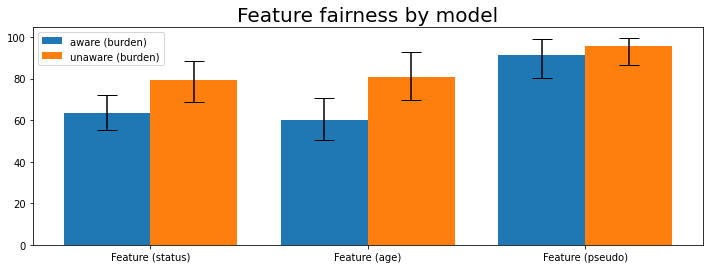

In [7]:
# Compare the fairness by feature measured for each model
df = pd.concat([construct_scores_dataframe(scores('fairness', result, max_depth=1)),
                construct_scores_dataframe(scores('fairness', result2, max_depth=1))])

pd.set_option('max_columns', None)
display(df)

print("\n")

%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (status)', 'Feature (age)', 'Feature (pseudo)']
feature_scores = df[features]
feature_lower_bounds = df[[f + ' lower bound' for f in features]]
feature_upper_bounds = df[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

ax.legend()
plt.show()

As expected the 'unaware' model improves in fairness on the 'aware' one, but still displays significant bias compared to the by-construction fair predictor.  This shows that simply removing a model's direct access to a feature can be helpful, but is far from a panacea.